In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from math import sqrt

import pickle
import os

In [2]:
# Lecture de nos données
df = pd.read_csv('export_infoclimat.csv', sep=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144645 entries, 0 to 144644
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   station_id      144645 non-null  object 
 1   dh_utc          144645 non-null  object 
 2   temperature     144548 non-null  float64
 3   pression        144645 non-null  float64
 4   humidite        144547 non-null  float64
 5   point_de_rosee  144547 non-null  float64
 6   vent_moyen      144455 non-null  float64
 7   vent_rafales    0 non-null       float64
 8   vent_direction  144546 non-null  float64
 9   pluie_3h        45197 non-null   float64
 10  pluie_1h        44748 non-null   float64
dtypes: float64(9), object(2)
memory usage: 12.1+ MB


In [4]:
print(df.isnull().sum())

station_id             0
dh_utc                 0
temperature           97
pression               0
humidite              98
point_de_rosee        98
vent_moyen           190
vent_rafales      144645
vent_direction        99
pluie_3h           99448
pluie_1h           99897
dtype: int64


In [5]:
# Formatage dans un format date
df['dh_utc'] = pd.to_datetime(df['dh_utc'])
df = df.set_index('dh_utc').sort_index()

# Suppression des colonne station_id (toujours identique) et vent_rafales (toujours nulle)
df = df.drop(columns=['station_id', 'vent_rafales'])

In [6]:
# Remplacement des valeurs nulles
df['pluie_3h'] = df['pluie_3h'].fillna(0)
df['pluie_1h'] = df['pluie_1h'].fillna(0)
for column in df.columns:
    if df[column].dtype in ['float64', 'int64'] and column not in ['pluie_3h', 'pluie_1h']:
        df[column] = df[column].fillna(df[column].mean())

In [7]:
# Regroupement des valeurs par jour
df_daily = df.resample('D').mean()
df_daily = df_daily.dropna()

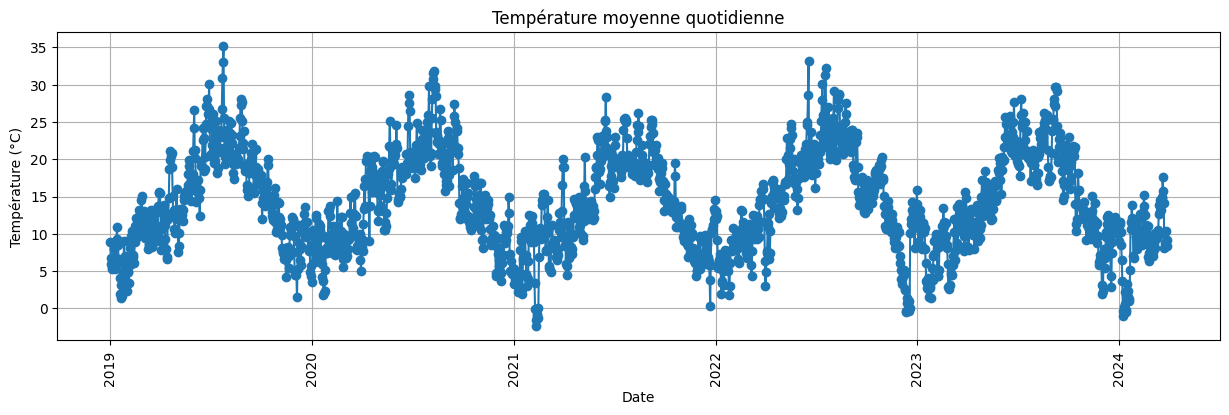

In [8]:
# Création d'un graphique pour visualiser les temperature
plt.figure(figsize=(15, 4))
plt.plot(df_daily['temperature'], marker='o', linestyle='-')
plt.gca().set(title='Température moyenne quotidienne', xlabel='Date', ylabel='Température (°C)')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [9]:
df_daily_temp = df['temperature'].resample('D').interpolate()

In [10]:
# Décomposition saisonière pour la temperature
result = seasonal_decompose(df_daily_temp, model='additive', period=365)

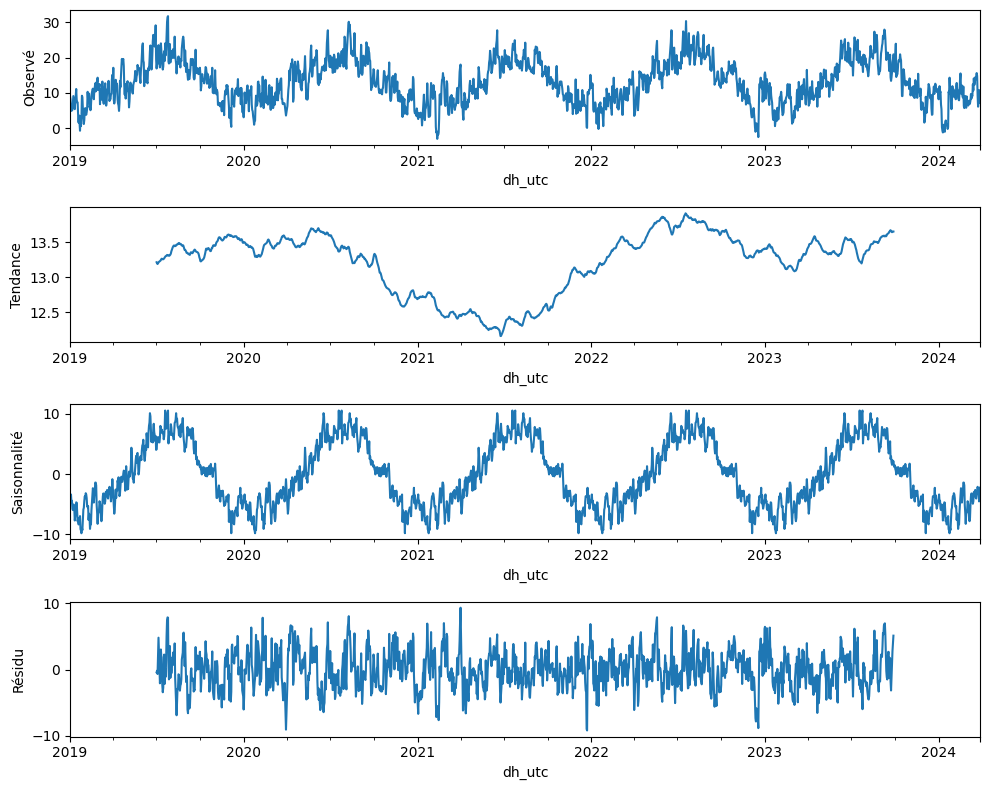

In [11]:
# Génération des graphiques
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observé')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Tendance')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Saisonnalité')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Résidu')
plt.tight_layout()
plt.show()

In [12]:
# Décomposition saisonière pour la pluie
df_daily_rain = df['pluie_1h'].resample('D').interpolate()
df_daily_rain = df_daily_rain.dropna()

In [13]:
result = seasonal_decompose(df_daily_rain, model='additive', period=365)

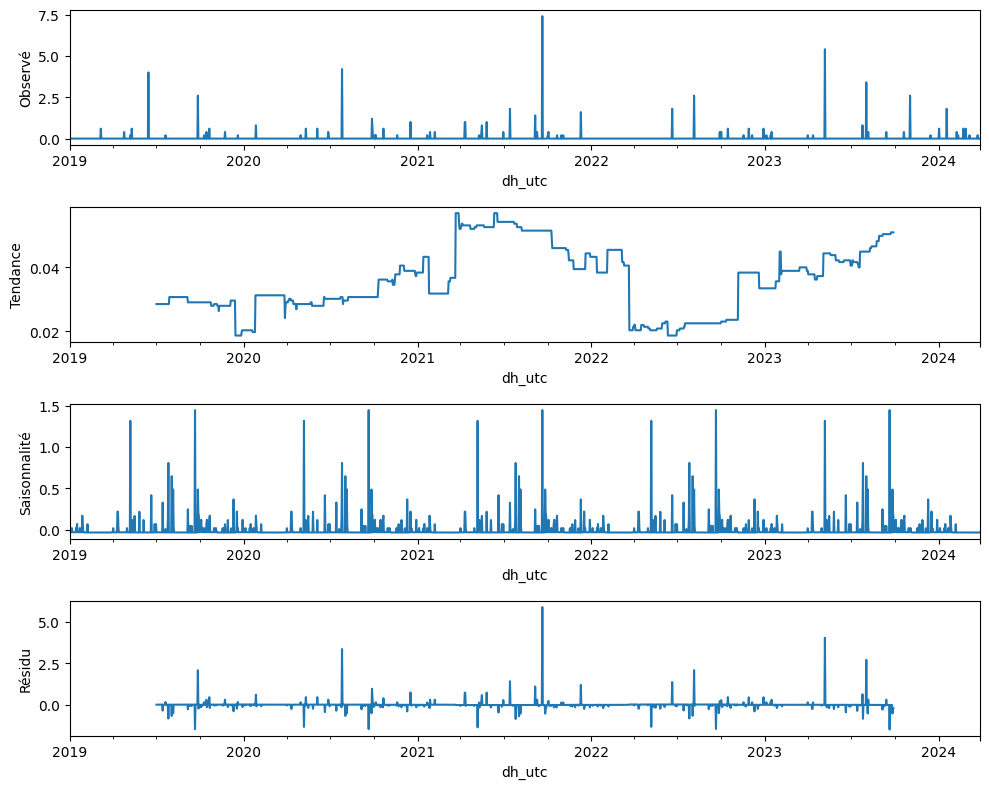

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observé')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Tendance')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Saisonnalité')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Résidu')
plt.tight_layout()
plt.show()

In [15]:
# Recuperation des dataset
def get_dataset(champ):
    train_df = df_daily.iloc[808:1903]
    X_train = train_df[champ]

    test_df = df_daily.iloc[1903:1913]
    X_test = test_df[champ]

    return (train_df, X_train, test_df, X_test)

In [16]:
# Fonction d'entrainement d'un model ARIMA sur un champ
def modelisation(champ):
    train_df, X_train, test_df, X_test = get_dataset(champ)

    model_ARIMA = ARIMA(X_train, order=(30, 1, 30))  
    results_ARIMA = model_ARIMA.fit()  
    rmse = sqrt(mean_squared_error(train_df[champ], results_ARIMA.fittedvalues))
    print('Test RMSE: %.3f' % rmse)
    return results_ARIMA

In [17]:
train_df, X_train, test_df, X_test = get_dataset('temperature')

In [18]:
# Entrainement de tous les modèles
temperature_model = modelisation('temperature')
pression_model = modelisation('pression')
humidite_model = modelisation('humidite')
rosee_model = modelisation('point_de_rosee')
vent_moyen_model = modelisation('vent_moyen')
vent_direction_model = modelisation('vent_direction')

c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

Test RMSE: 1.885


c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

Test RMSE: 31.345


c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

Test RMSE: 7.349


c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

Test RMSE: 2.017


c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

Test RMSE: 2.156


c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

Test RMSE: 46.229


In [19]:
# Export de tous les modèles
if not os.path.exists('./models'):
    os.mkdir('models')
    pass
with open('models/temperature_model.pickle', "wb") as file:
    pickle.dump(temperature_model, file)
with open('models/pression_model.pickle', "wb") as file:
    pickle.dump(pression_model, file)
with open('models/humidite_model.pickle', "wb") as file:
    pickle.dump(humidite_model, file)
with open('models/rosee_model.pickle', "wb") as file:
    pickle.dump(rosee_model, file)
with open('models/vent_moyen_model.pickle', "wb") as file:
    pickle.dump(vent_moyen_model, file)
with open('models/vent_direction_model.pickle', "wb") as file:
    pickle.dump(vent_direction_model, file)

In [20]:
# # Pour relancer avec les données de test

# champ = ''

# train_df, X_train, test_df, X_test = get_dataset(champ)

# history_temp = [x for x in train_df]
# predictions_temp = list()

# # walk-forward validation
# for t in range(len(X_test)):
#     model = ARIMA(history_temp, order=(30, 1, 30))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat = output[0]
#     obs = week_test.iloc[t]
#     predictions_temp.append(yhat)
#     history_temp.append(obs)
#     print('predicted=' + str(yhat) +', expected=' + str(obs))